# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [4]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

import hvplot as hv
import hvplot.pandas
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from itertools import product                    # some useful functions
from pathlib import Path
from pypalettes import load_cmap, add_cmap
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                   # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [12, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [3]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [8]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## Vorbereitungen des Daten df_hourly für SARIMAX
### ACF und PACF für df_hourly

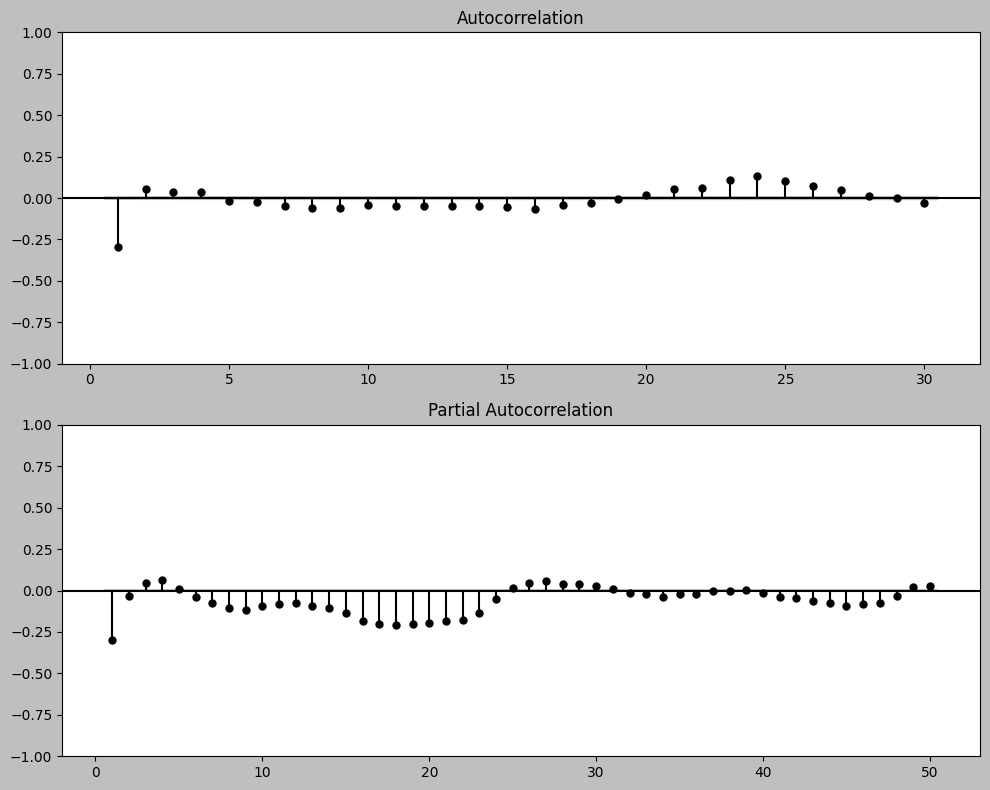

In [13]:
# ACF und PACF
# Nur die Spalte 'calls' auswählen und Differenz berechnen
hourly_diff = df_hourly['calls'].diff().dropna()

# ACF und PACF Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(hourly_diff, zero=False, lags=30, ax=ax[0])
plot_pacf(hourly_diff, zero=False, lags=50, ax=ax[1])
plt.tight_layout()
plt.show()


In [14]:
# Make Time Series Stationary
# Anwendung auf df_hourly
hourly_diff_24 = df_hourly['calls'].diff(24).dropna()
check_stationarity(hourly_diff_24)

'Stationary	 p-value:0.0 	 lags:51


('Stationary', 0.0)

                                        SARIMAX Results                                        
Dep. Variable:                                   calls   No. Observations:                30672
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 24)   Log Likelihood              -88232.501
Date:                                 Tue, 07 Jan 2025   AIC                         176477.001
Time:                                         15:01:20   BIC                         176526.983
Sample:                                              0   HQIC                        176493.022
                                               - 30672                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8355      0.006    130.405      0.000       0.823       0

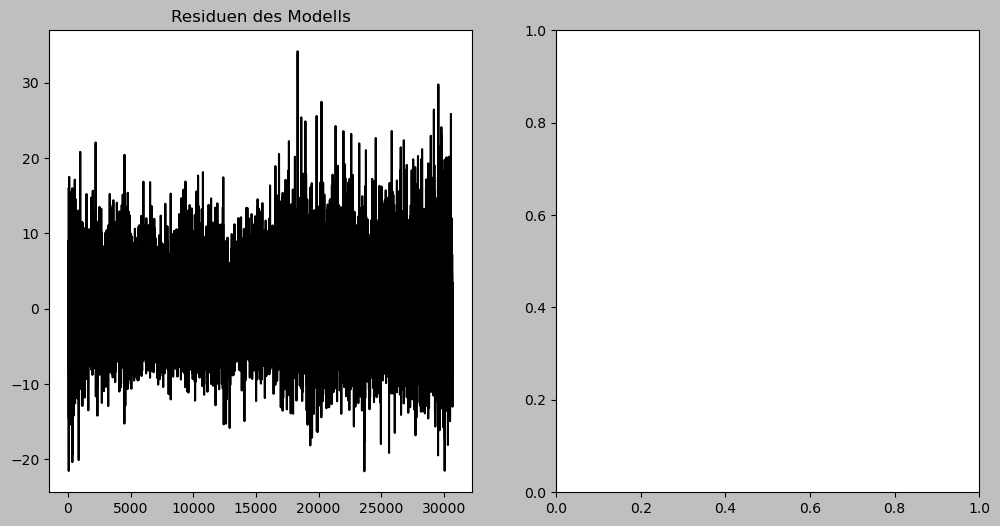

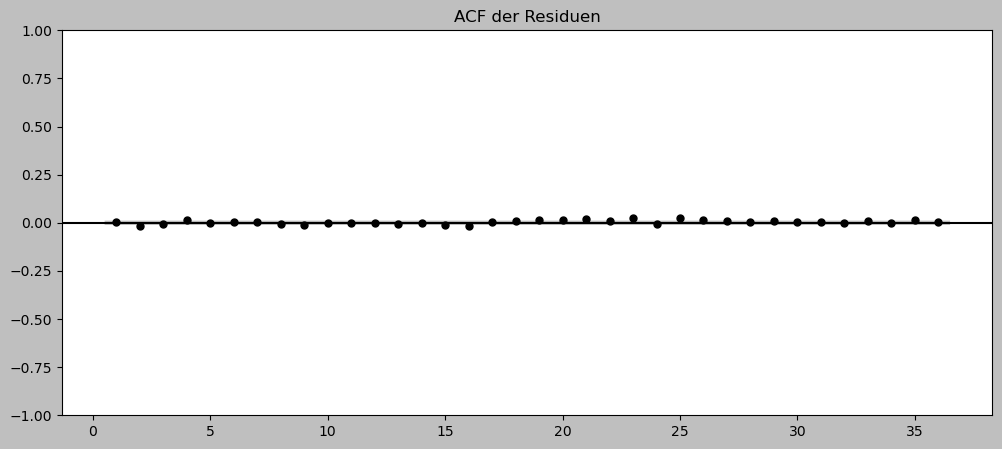

In [12]:
model = SARIMAX(hourly_diff_24, 
                order=(1,0,1), 
                seasonal_order=(1,1,2,24)).fit(disp=False)
print(model.summary())
## Das ist bisher das beste Modell 

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                                calls   No. Observations:                30672
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 24)   Log Likelihood              -88077.262
Date:                              Wed, 15 Jan 2025   AIC                         176166.523
Time:                                      08:54:51   BIC                         176216.510
Sample:                                           0   HQIC                        176182.545
                                            - 30672                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8047      0.008    104.442      0.000       0.790       0.820
ma.L1         -1.59

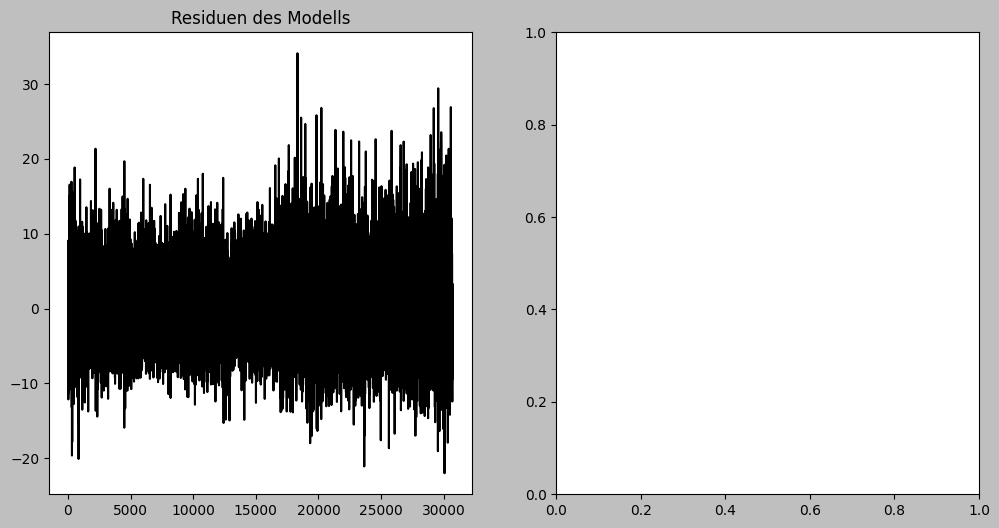

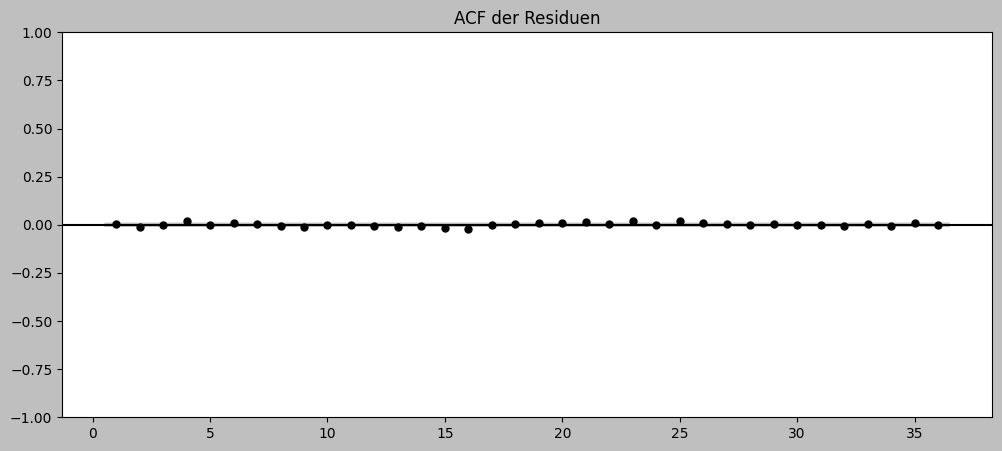

In [19]:
# Werte aus HPO mit Optuna
model = SARIMAX(hourly_diff_24, 
                order=(1,1,2), 
                seasonal_order=(1,0,1,24)).fit(disp=False)
print(model.summary())
## Das ist bisher das beste Modell 

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()


## Vorbereitung von df_daily für SARIMAX

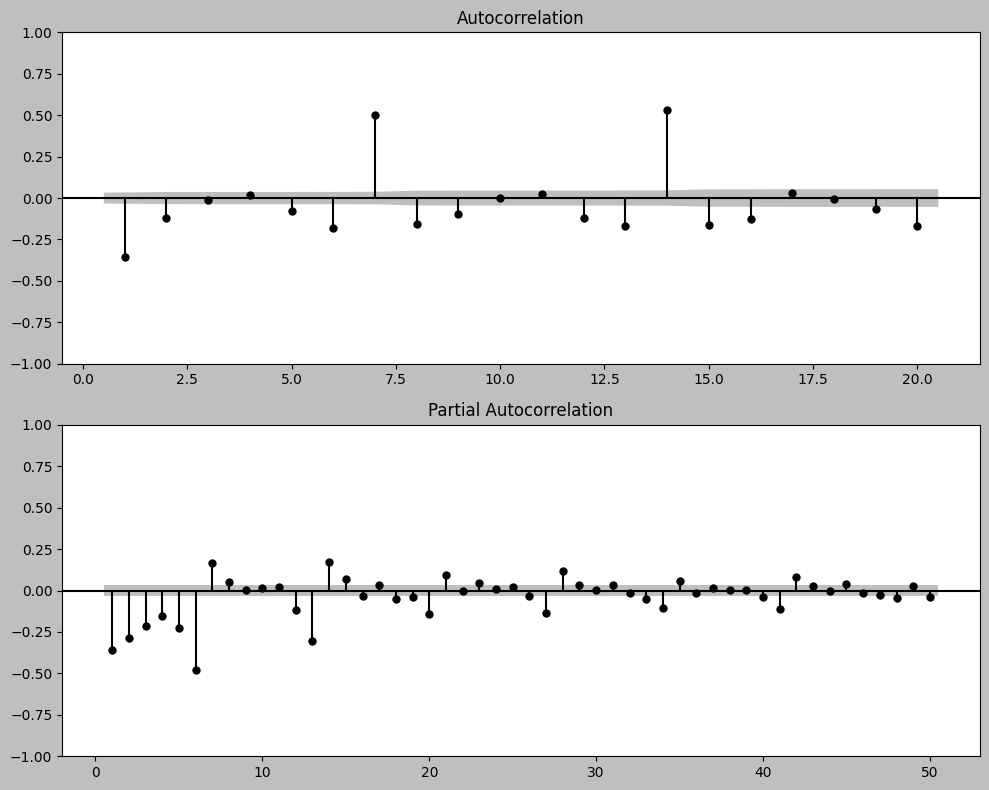

In [20]:
# ACF und PACF
# Nur die Spalte 'calls' auswählen und Differenz berechnen
daily_diff = df_daily['calls'].diff().dropna()

# ACF und PACF Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(daily_diff, zero=False, lags=20, ax=ax[0])
plot_pacf(daily_diff, zero=False, lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

In [21]:
# Datensatz stationär werden lassen 
# Anwendung auf df_daily
daily_diff_7 = df_daily['calls'].diff(7).dropna()
check_stationarity(daily_diff_7)

'Stationary	 p-value:2.4490544761314682e-23 	 lags:28


('Stationary', np.float64(2.4490544761314682e-23))

In [23]:
ljung_box_result = acorr_ljungbox(daily_diff_7, lags=[10, 20, 30], return_df=True)
print(ljung_box_result)

        lb_stat      lb_pvalue
10  1298.013737  1.026514e-272
20  1370.588213  2.235701e-278
30  1415.835599  3.335950e-279
